# IL2232 Embedded Systems Design Project
## Project group: Embedded Time Series Analysis - Joshua Sadiq
## ARIMA-model preparation script

Purpose of this script is to:
1. Prepare data set
2. Prepare ARIMA model and find a good fit
3. Present fitting model (which will be implemented in C++ on an ESP32)

### Import libraries

In [5]:
# Data management
import numpy as np
import pandas as pd

# Tests
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error as mse, mean_absolute_percentage_error as mape, mean_absolute_error as mae

# ARIMA construction
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA


# Plotting
from matplotlib.pyplot import plot, figure, title, xlabel, ylabel, legend, show, savefig, boxplot
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from seaborn import heatmap

# Benchmarking
import time
import sys

### Helper functions   

In [6]:
# Loads data set from CSV file, given filename as input
# Returns both numpy array and Pandas DataFrame
# The latter is simpler to implement as plots
def load_csv_data(file_name : str):
    data_np = np.loadtxt(file_name, delimiter = ",", dtype = float)
    data_pd = pd.read_csv(file_name, names = ["Year", "Value"])

    return data_np, data_pd

# Test for stationarity
def adfuller_test(data_set: pd.core.frame.DataFrame):
    result = adfuller(data_set.loc[:, "Value"], autolag='AIC')
    adfstat = result[0]
    pvalue = result[1]
    print("-"*30)
    print(f'ADF Statistic: {adfstat}')
    print(f'p-value: {pvalue}')

    critvals_lt_adfstat = 0
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'{key}, {value}')
        if (value < adfstat):
            critvals_lt_adfstat += 1
    print("-"*30)
    print(f"Critical values less than adf statistic: {critvals_lt_adfstat}")
    print(f"p-value is below the 5% significance level: {pvalue < 0.05}")
    print(f"Stationary? {critvals_lt_adfstat == 0 and pvalue < 0.05}")
    print("-"*30)
    print("")

# Line plot, histogram, density plot, heat map, box plot, lag-1 plot, lag-2 plot, ACF/PACF plots
# Pandas DataFrame structure allows simple implementation of plots
def plot_all(data_set : pd.core.frame.DataFrame, lags : int = 40, xlabel : str = "Values", title : str = ""):
    fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(25, 25))
    fig.subplots_adjust()
    fig.suptitle(title, fontsize=24)
    
    # Line plot
    data_set.plot(y = "Value", ax = axes[0,0], kind = 'line', title = 'Line plot')

    # Histogram plot
    data_set.plot(x = "Year", y = "Value",ax = axes[0,1], kind = 'hist', title = 'Histogram', ylabel = 'Frequency')

    # Density plot
    data_set.plot(x = "Year", y = "Value",ax = axes[1,0], kind = 'density', title = 'Density plot', ylabel = 'Density')
    
    # Heatmap
    heatmap_data_set = data_set.set_index("Year")
    heatmap(heatmap_data_set, ax = axes[1,1], cmap = "viridis")

    # Box plot
    data_set.plot(x = "Year", y = "Value",ax = axes[2,0], kind = 'box', title = 'Box plot')
    
    # Lag plots
    data_set_series = pd.Series(data_set.loc[:, 'Value'])
    pd.plotting.lag_plot(data_set_series, ax = axes[3,0], lag = 1)
    pd.plotting.lag_plot(data_set_series, ax = axes[3,1], lag = 2)

    # ACF and PACF plots
    plot_acf(data_set_series, ax = axes[4,0])
    plot_pacf(data_set_series, lags = lags, ax=axes[4,1], method='ywm');

### EDA

It is always a good practice to explore and analyze the data set before handling it:

In [10]:
# Load data
# If using Windows, change / to \\
data_np, data_pd = load_csv_data("Data sets/temp_anom.csv")

# Check for stationarity
adfuller_test(data_pd)

------------------------------
ADF Statistic: 0.9382926419378815
p-value: 0.993570249862259
Critial Values:
1%, -3.479007355368944
5%, -2.8828782366015093
10%, -2.5781488587564603
------------------------------
Critical values less than adf statistic: 3
p-value is below the 5% significance level: False
Stationary? False
------------------------------



As data is *not* stationary, we conduct a first-order differencing as an attempt to solve this. We analyze our results by running another ADF test

In [11]:
# Difference data
diff_data_set = data_pd.diff().dropna()

# Check for stationarity
adfuller_test(diff_data_set)

------------------------------
ADF Statistic: -12.165503286659833
p-value: 1.4604869372131342e-22
Critial Values:
1%, -3.479007355368944
5%, -2.8828782366015093
10%, -2.5781488587564603
------------------------------
Critical values less than adf statistic: 0
p-value is below the 5% significance level: True
Stationary? True
------------------------------



We proceed to plot the data in relevant graphs to inspect the differenced dataset

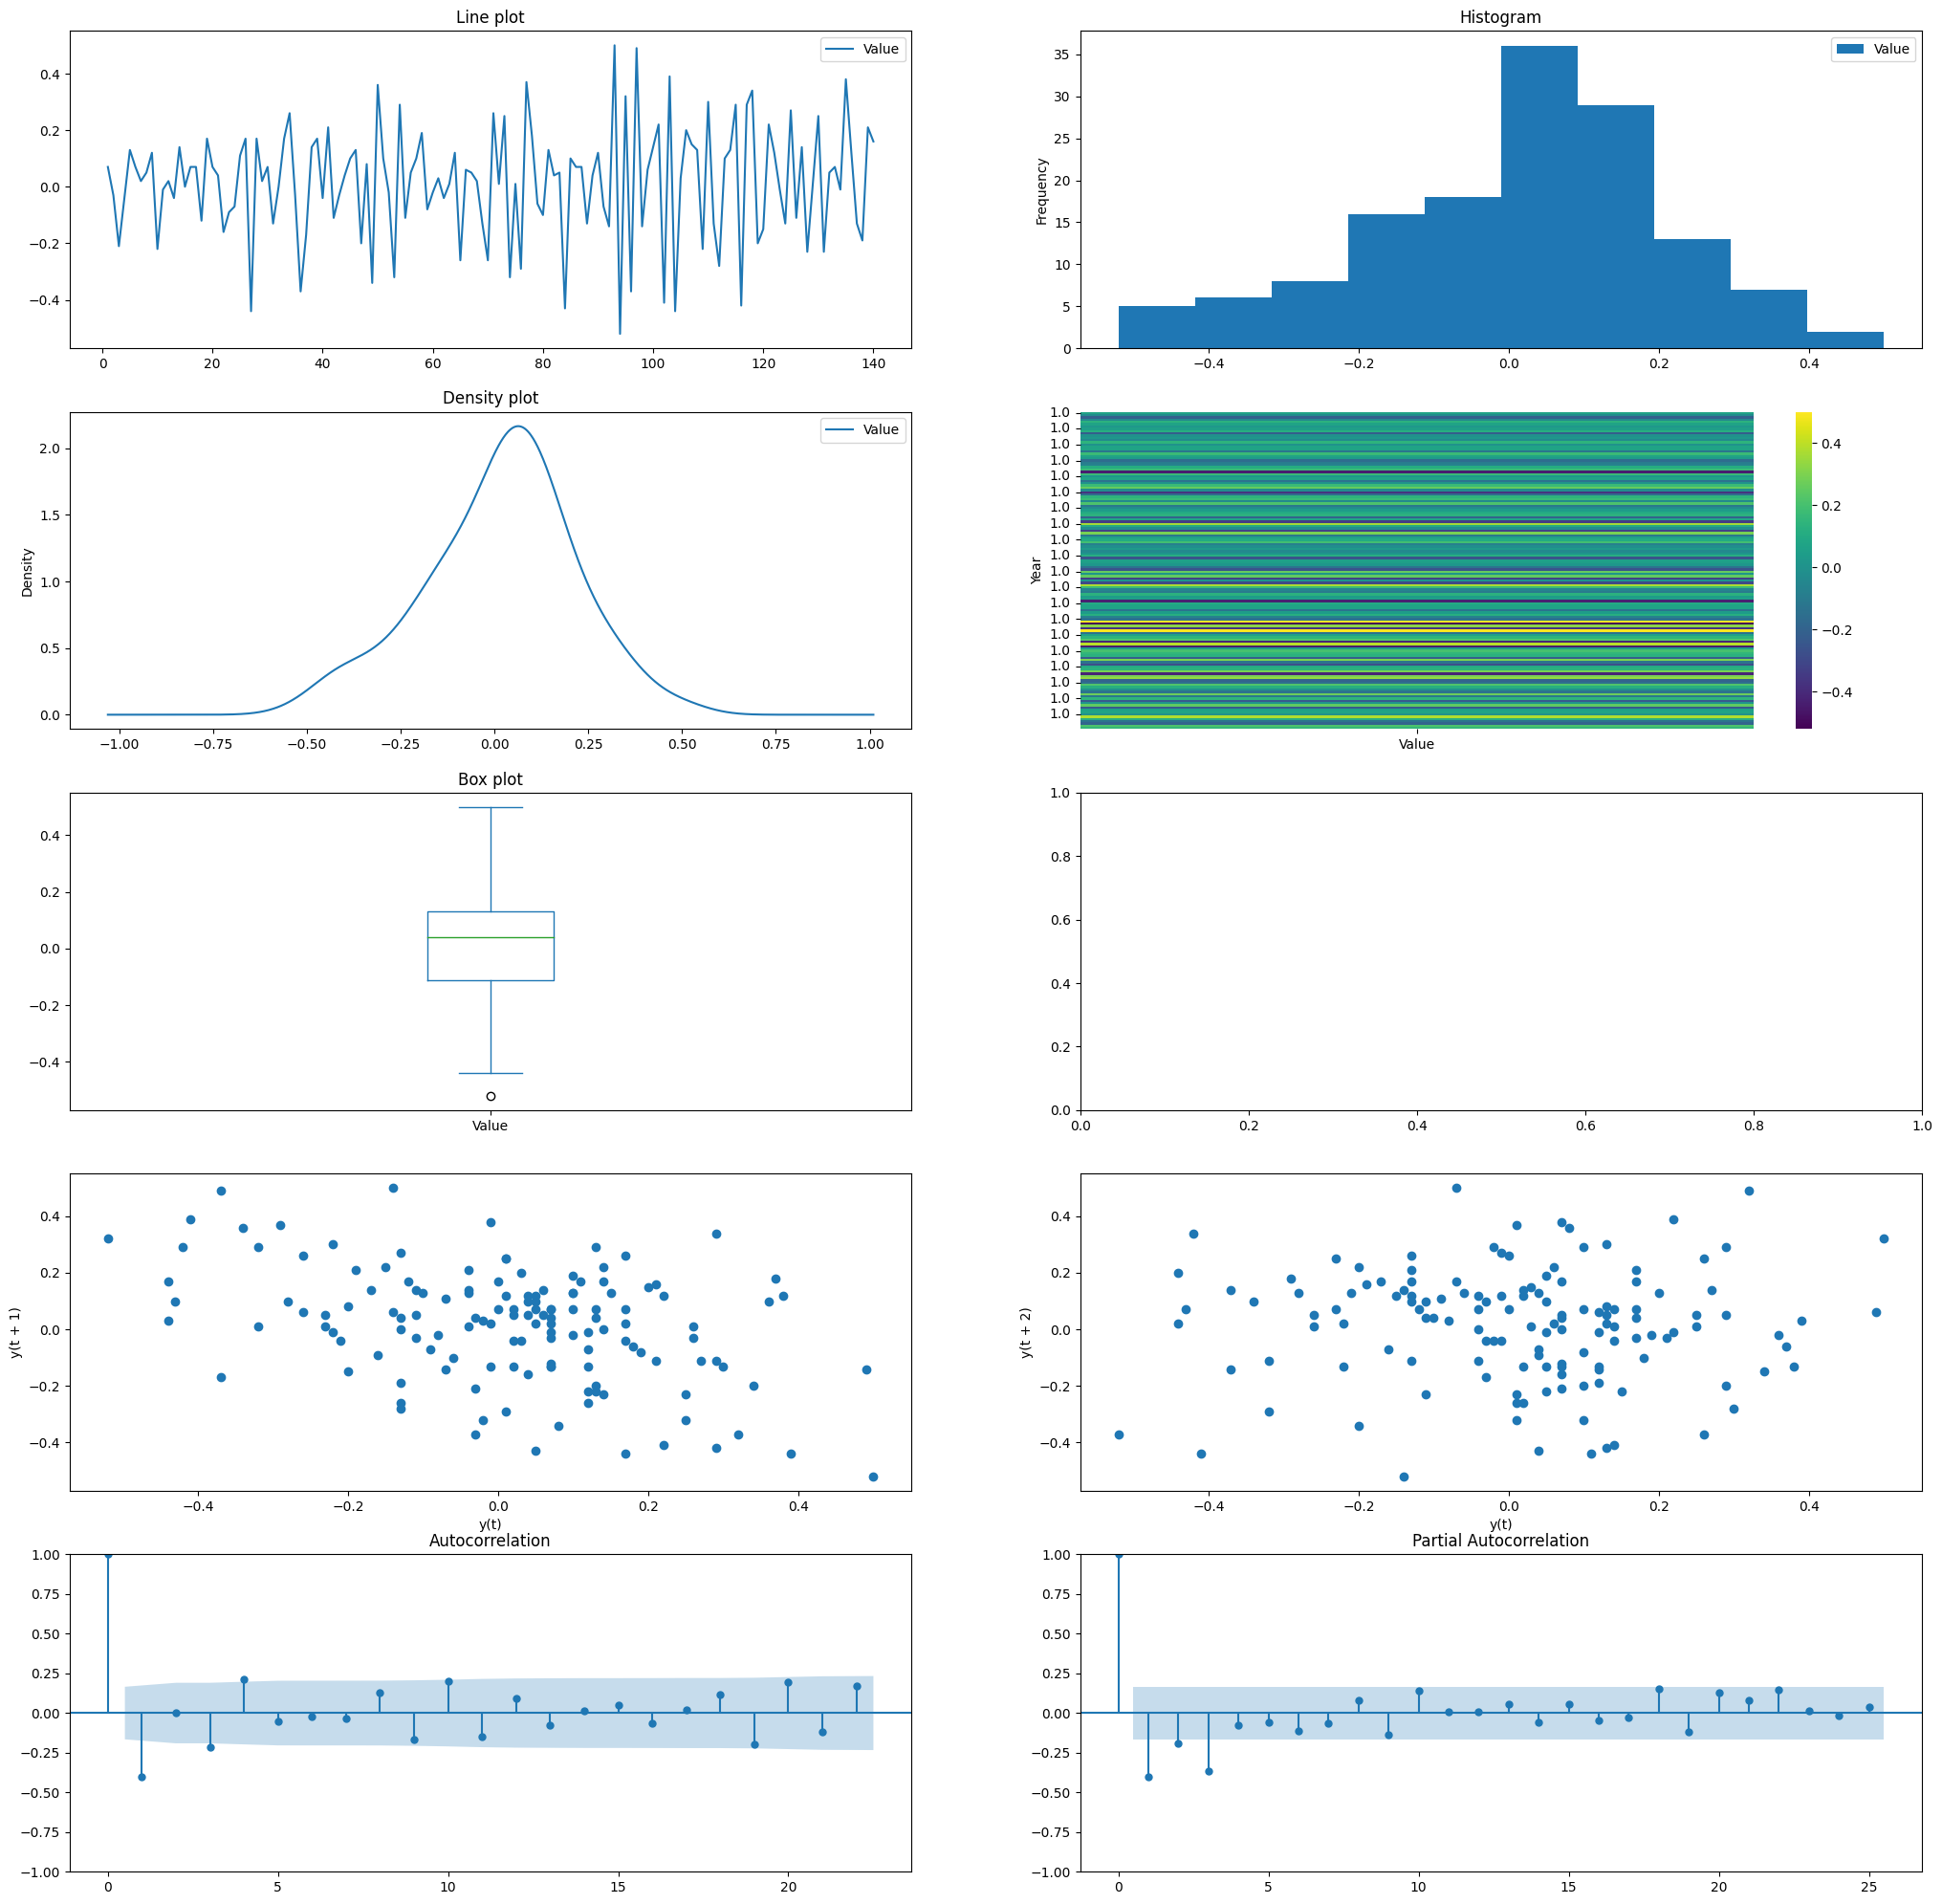

In [12]:
# Plot data
plot_all(diff_data_set, lags = 25)

### Model Construction and Selection

We follow Box-Jenkins methodology to construct an ARIMA-model.

Step 1 requires us to check for stationarity (and, if it does not exist, ensure stationarity through differencing) followed by considering seasonality (in which case, a SARIMA-model must be considered). Our data set has already achieved stationarity, and no signs of seasonality can be seen. Furthermore, as we have applied differencing to ensure stationarity, the order of *d* can be found to be one considering we have differenced it once.

Step 2 asks us to identify the orders of the ARIMA-model. One method to accomplish this is from the ACF and PACF plots, which reveal the MA(p) and AR(q) values. By finding the first occurrence of a lag which falls within the confidence interval, we can determine the order of *p* from the PACF, and the order of *q* from the ACF. Visual identification reveals these to be *4* and *2*, respectively.

Step 3 has us combine the MA- and AR-processes into an ARIMA-process, and finding the fitting *p* and *q* values for the combined process. This can be done using the AIC criterion, which the $\texttt{auto\_arima()}$ function handles for us. This step handles the construction of the model, as done below.

The optimal model seems to be using (p, d, q) = (2, 1, 4) as attributes. We construct it below as well.

In [13]:
# Auto_arima runs a grid-patterned test to find the optimal p,d,q attributes using AIC-criterion by default
diff_series = diff_data_set["Value"]
diff_series.index = diff_data_set["Year"]
diff_series = pd.Series(diff_series).dropna()
auto_arima(diff_series, start_p = 0, max_p = 5, d = 1, start_q = 0, max_q = 5, seasonal = False, trace = True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=93.740, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=21.236, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=91.741, Time=0.02 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=7.489, Time=0.07 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-27.815, Time=0.19 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=-42.862, Time=0.35 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=-47.324, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=-82.962, Time=0.68 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.79 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.74 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=-81.387, Time=0.64 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=-85.108, Time=0.41 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=-86.478, Time=0.40 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=-87.512, Time=0.27 sec

ARIMA(order=(2, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

We create a model using statsmodels ARIMA-function below. This one fits the differenced dataset to a model with parameters as established above.

In [14]:
model = ARIMA(endog = diff_series, order=(2, 1, 4)).fit()

/home/zanilicious/Documents/IL2232/IL2232-main/ARIMA/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zanilicious/Documents/IL2232/IL2232-main/ARIMA/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zanilicious/Documents/IL2232/IL2232-main/ARIMA/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


We proceed to benchmark the inference time and size of the model.

Note: If inference time shows 0.0 seconds, continuously run the cell below until a result can be seen.
This "bug" is most likely due to the inference time sometimes falling a power shorter than what the print-function deems relevant resolution.

In [15]:
start_time = time.time()
model_prediction = model.predict()
print("--- Inference time: %s seconds ---" % (time.time() - start_time))
predicted_data_set = model_prediction
predicted_data_set

print("--- Memory usage: %s Bytes" % sys.getsizeof(model_prediction))


--- Inference time: 0.004283428192138672 seconds ---
--- Memory usage: 2256 Bytes


The prediction's scores are noted for future testing.

In [16]:
arima_mse = mse(diff_series, model_prediction)
arima_mae = mae(diff_series, model_prediction)
arima_mape = mape(diff_series, model_prediction)
print('Test MSE: %.4f' % arima_mse)
print('Test MAE: %.4f' % arima_mae)
print('Test MAPE: %.4f' % arima_mape)


Test MSE: 0.0264
Test MAE: 0.1318
Test MAPE: 5990359572758.0869


An in-sample prediction of the model is taken and compared to the actual dataset. It shows relatively decent accuracy.

In [17]:
# model_prediction_index = list(range(0, 140))
# model_prediction.reindex(model_prediction_index)
model_pred_list = model_prediction.tolist()

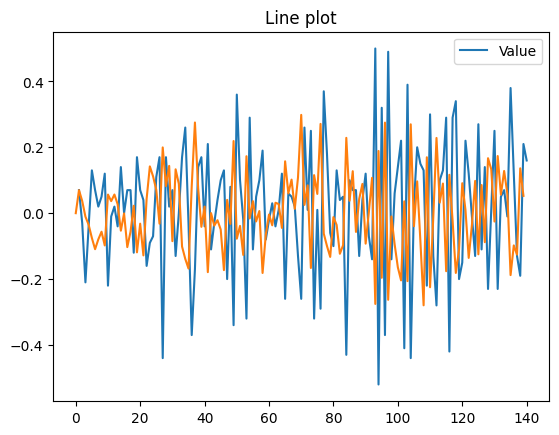

In [18]:
diff_data_set.plot(y = "Value", kind = 'line', title = 'Line plot')
plot(model_pred_list)

In [ ]:
# diff_data_set
# model_prediction

At this point, we have explored the data set, considered stationarity and seasonality, found the fitting AR- and MA-parameters respectively, and combined them to find the ARIMA-parameters.

We now have the model's correct parameters. Further tests would be to ensure that this is a good fit, but the next action is to implement this ARIMA-model in C++.

Below, we attempt to extract the model from the internal parameters of the ARIMA-function:

In [19]:
model_names = ARIMA(endog = diff_series, order=(2, 1, 4)).param_names

model_names

/home/zanilicious/Documents/IL2232/IL2232-main/ARIMA/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zanilicious/Documents/IL2232/IL2232-main/ARIMA/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/zanilicious/Documents/IL2232/IL2232-main/ARIMA/.venv/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


['ar.L1', 'ar.L2', 'ma.L1', 'ma.L2', 'ma.L3', 'ma.L4', 'sigma2']

Below, we find the six various coefficients necessary for construction the equation (As written in the report).

In [20]:
dir(model) # Gets various attributes of model
getattr(model, "params") # Returns value of attributes NOTE: params
# https://people.duke.edu/~rnau/411arim.htm#spreadsheet

ar.L1    -1.086121
ar.L2    -0.672413
ma.L1    -0.537430
ma.L2    -0.522411
ma.L3    -0.619017
ma.L4     0.723444
sigma2    0.025872
dtype: float64

In the following, we will attempt to try creating the ARIMA model from scratch, using the parameters from previous code block

In [21]:
# Original data
A = [-0.50,-0.43,-0.46,-0.67,-0.71,-0.58,-0.51,-0.49,-0.44,-0.32,-0.54,-0.55,-0.53,-0.57,-0.43,-0.43,-0.36,-0.29,-0.41,-0.24,-0.17,-0.13,-0.29,-0.38,-0.45,-0.34,-0.17,-0.61,-0.44,-0.42,-0.35,-0.48,-0.48,-0.31,-0.05,-0.08,-0.45,-0.62,-0.48,-0.31,-0.35,-0.14,-0.25,-0.28,-0.24,-0.14,-0.01,-0.21,-0.13,-0.47,-0.11,-0.01,-0.03,-0.35,-0.06,-0.17,-0.12,-0.02,0.17,0.09,0.07,0.10,0.06,0.07,0.19,-0.07,-0.01,0.04,0.06,-0.07,-0.33,-0.07,-0.06,0.19,-0.13,-0.12,-0.41,-0.04,0.14,0.08,-0.02,0.11,0.15,0.20,-0.23,-0.13,-0.06,0.01,-0.12,-0.08,0.04,-0.03,-0.17,0.33,-0.19,0.13,-0.24,0.25,0.11,0.17,0.31,0.53,0.12,0.51,0.07,0.10,0.30,0.45,0.58,0.36,0.66,0.53,0.25,0.35,0.48,0.77,0.35,0.64,0.98,0.78,0.63,0.85,0.97,0.96,0.83,1.10,0.99,1.13,0.90,0.91,1.16,0.93,0.98,1.05,1.04,1.42,1.54,1.41,1.22,1.43,1.59]

# Prediction array
B = []

# Errors array
C = []

# Parameters from above
params = [-1.086464,
        -0.672785,
        -0.537128,
        -0.522477,
        -0.619176,
        0.723350]

# Benchmarking inference time
start_time = time.time()

# Loop for producing in-sample prediction (and future forecasting if range end size is increased)
for i in range(0, len(A)):
    calc = 0
    err = 0

    # Since initial values of prediction and error are missing in varying degree during first five runs,
    # calculations increase over time
    if (i - 1 >= 0):
        calc += params[0]*A[i-1]    # y_t-1
        err = A[i] - calc

    if (i - 2 >= 0):
        calc += params[1]*A[i-2]    # y_t-2
        calc += params[2]*C[i-1]    # err_t-1

    if (i - 3 >= 0):
        calc += params[3]*C[i-2]    # err_t-2

    if (i - 4 >= 0):
        calc += params[4]*C[i-3]    # err_t-3

    if (i - 5 >= 0):
        calc += params[5]*C[i-4]    # err_t-3
 

    B.append(calc)
    C.append(err)
# Print inference time
# Note: Similar bug to aforementioned issue, not sure why it shows 0 seconds, re-run code block until time is shown
print("--- %.15f seconds ---" % (time.time() - start_time))


--- 0.000873565673828 seconds ---


Finally, we plot the in-sample prediction below to compare it with the previous graph.
We find that the algorithm is not very accurate through visual inspection of the plot. This is left as future work.
The algorithm above is implemented into the ESP32 in the C++ engine found in main.cpp

<Axes: title={'center': 'Line plot'}>

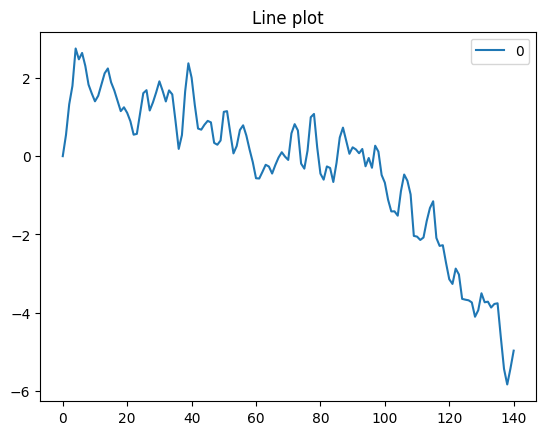

In [22]:
B_pd = pd.DataFrame(B)

B_pd.plot(kind = 'line', title = 'Line plot')
